In [54]:
# Import packages
from osgeo import gdal
import os
import glob

import matplotlib.pyplot as plt
#from mpl_toolkits.axes_grid1 import make_axes_locatabl
import numpy as np
import rasterio
import xarray
import rioxarray
import datetime

In [100]:
# Define filepaths
filepath7 = '/Users/jsheppar/Downloads/landsat7/'
filepath8 = '/Users/jsheppar/Downloads/landsat8/'
filepath_DF_mask = '/Users/jsheppar/Documents/GitHub/Landslide_NDVI/DF_area1.tif.aux/test_DF_area1_32610.tif'
filepath_DF_ownership = '/Users/jsheppar/Documents/GitHub/Landslide_NDVI/Ownership_DF/test_Ownership_DF_32610.tif'

# Define list of Landsat bands
files7 = sorted(glob.glob(filepath7 + '*.tif'))
files8 = sorted(glob.glob(filepath8 + '*.tif'))

In [97]:
def process_ndvi_7(file):
    #strip name from filepath for later
    name = file.split("/")[-1]
    xds = rioxarray.open_rasterio(file)
    
    #select band 4 and 3 from landsat 7 tif
    band4 = xds.sel(band=1)
    band3 = xds.sel(band=2)
    #band2 = xds.sel(band=3)
    
    # Compute NDVI
    ndvi = np.divide((band4 - band3), (band4 + band3))
    
    # clip to shape of Douglas Fire
    clipped_ndvi = ndvi.where(df_mask == 1)
    clipped_ndvi = clipped_ndvi.transpose('band', 'y', 'x')
    
    clipped_ndvi.rio.to_raster("/Users/jsheppar/Downloads/landsat_ndvi/ndvi_"+name)
    
def process_ndvi_8(file):
    name = file.split("/")[-1]
    xds = rioxarray.open_rasterio(file)
    
    band5 = xds.sel(band=1)
    band4 = xds.sel(band=2)
    #band3 = xds.sel(band=3)
    
    # Compute NDVI
    #p.seterr(divide='ignore', invalid='ignore')
    ndvi = np.divide((band5 - band4), (band5 + band4))
                   
    # clip to shape of Douglas Fire
    clipped_ndvi = ndvi.where(df_mask == 1)
    clipped_ndvi = clipped_ndvi.transpose('band', 'y', 'x')               
    
    clipped_ndvi.rio.to_raster("/Users/jsheppar/Downloads/landsat_ndvi/ndvi_"+name)

In [101]:
df_mask = rioxarray.open_rasterio(filepath_DF_mask)
df_ownership = rioxarray.open_rasterio(filepath_DF_ownership)

In [ ]:
for file in files7:
    process_ndvi_7(file)

for file in files8:
    process_ndvi_8(file)

Next task: apply ownership mask, and make either boxplot of each option for each image OR resample time if the plot is too messy AND/OR don't do boxplots, instead do scatter plot with standard deviation or something around each point?

In [123]:
def create_timeseries(files):
    times = []
    for name in files:
        times.append(name.split("_")[-1].split(".")[0])
        
    dates = []    
    for date in times:
        # format
        format = '%Y%m%d'

        # convert from string format to datetime format
        datetime_var = datetime.datetime.strptime(date, format)

        # get the date from the datetime using date()
        dates.append(datetime_var.date())
    return dates
        

def analyze_ownership(file):
    ndvi = rioxarray.open_rasterio(file)
    t = ndvi.squeeze(drop=True, axis=0)
    
    # 1 = private, 0 = BLM
    private_ndvi = ndvi.where(df_ownership == 1)
    private_ndvi = private_ndvi.squeeze(drop=True, axis=0)
    
    blm_ndvi = ndvi.where(df_ownership == 0)
    blm_ndvi = blm_ndvi.squeeze(drop=True, axis=0)
    
    return private_ndvi.values.flatten(), blm_ndvi.values.flatten()

In [146]:
filepath_ndvi = '/Users/jsheppar/Downloads/landsat_ndvi/'
files_ndvi = sorted(glob.glob(filepath_ndvi + '*.tif'))

times = create_timeseries(files_ndvi)
times.sort()

In [148]:
ownership_flattened_priv = []
ownership_flattened_blm = []

for file in files_ndvi:
    priv, blm = analyze_ownership(file)
    ownership_flattened_priv.append(priv)
    ownership_flattened_blm.append(blm)

In [149]:
for ii in range(len(ownership_flattened_priv)):
    ownership_flattened_priv[ii] = ownership_flattened_priv[ii][~np.isnan(ownership_flattened_priv[ii])]
for ii in range(len(ownership_flattened_blm)):
    ownership_flattened_blm[ii] = ownership_flattened_blm[ii][~np.isnan(ownership_flattened_blm[ii])]

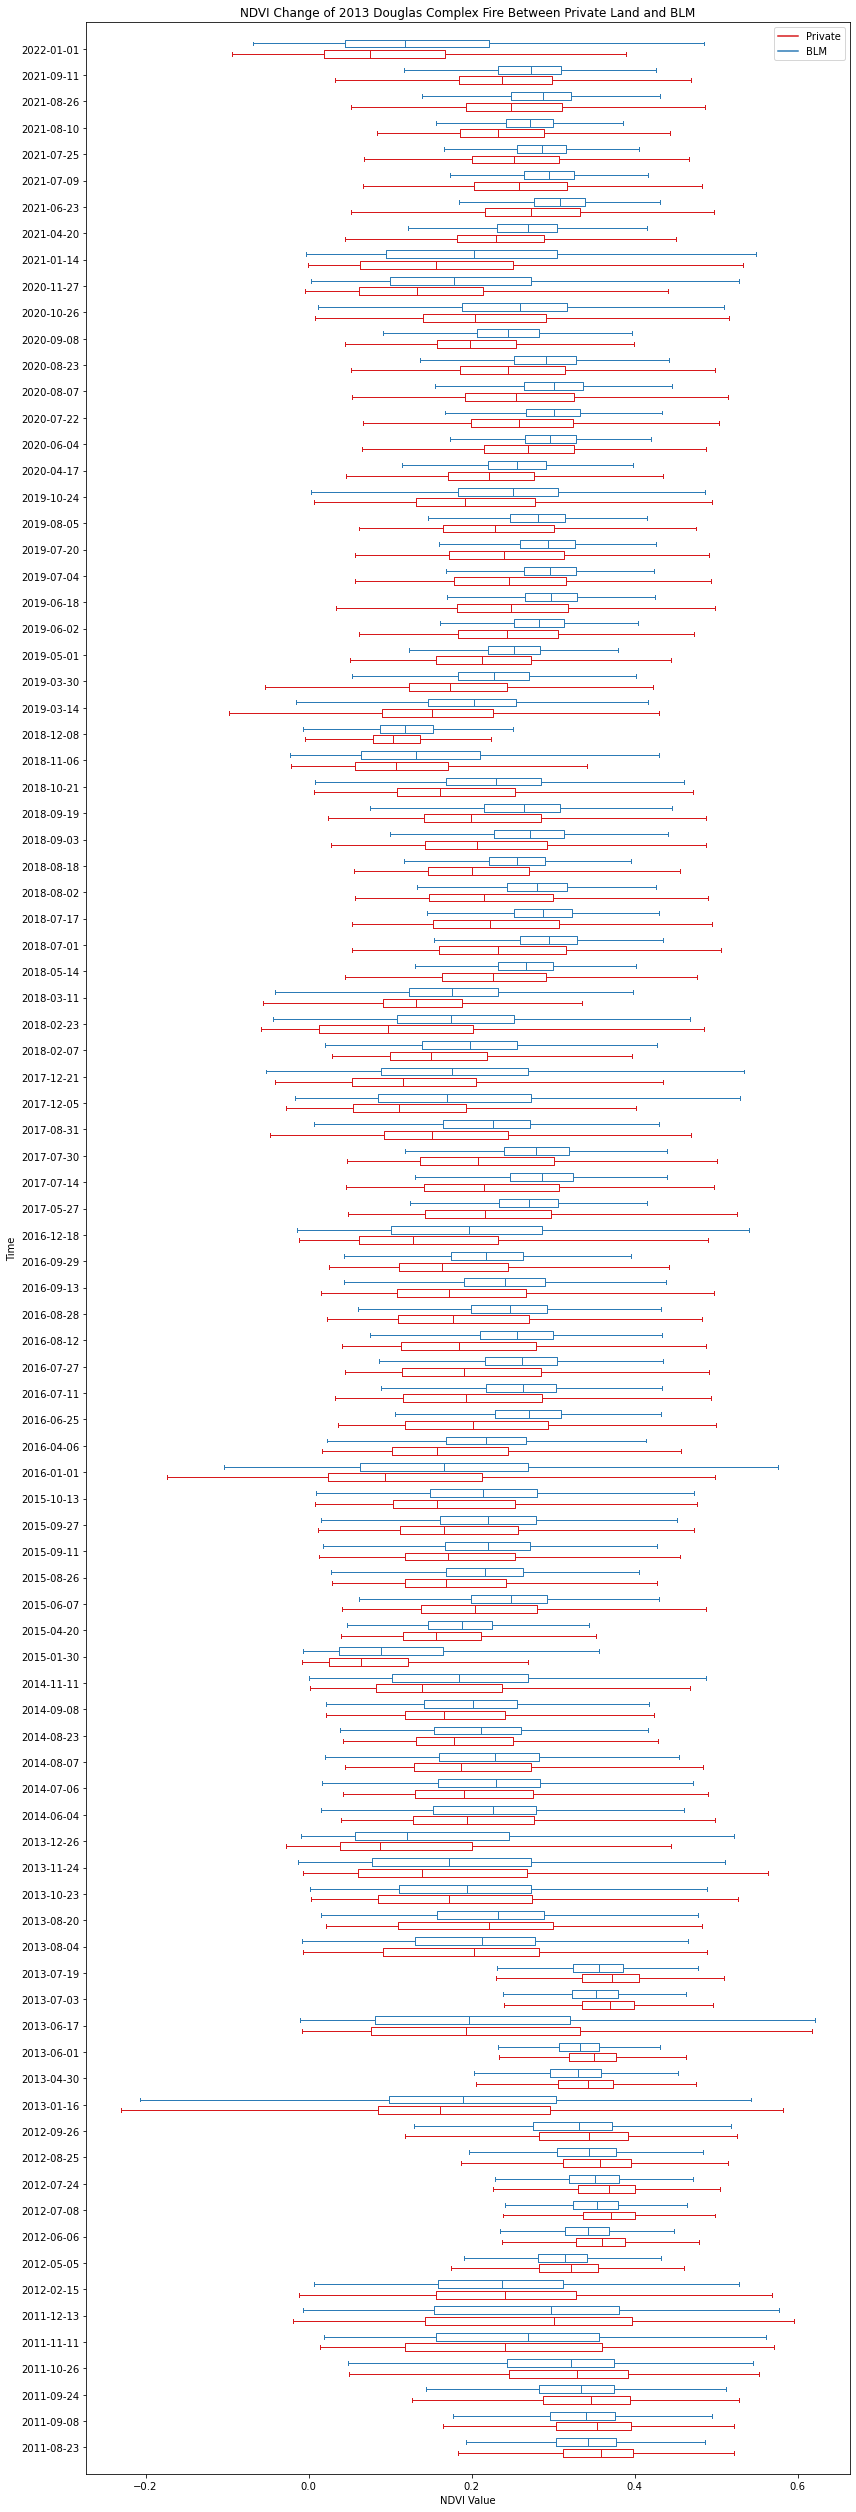

In [153]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize=(12, 35))

bpl = plt.boxplot(ownership_flattened_priv, positions=np.array(range(len(ownership_flattened_priv)))*2.0-0.4, sym='', widths=0.6, vert = 0)
bpr = plt.boxplot(ownership_flattened_blm, positions=np.array(range(len(ownership_flattened_blm)))*2.0+0.4, sym='', widths=0.6, vert = 0)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Private')
plt.plot([], c='#2C7BB6', label='BLM')
plt.legend()

plt.yticks(range(0, len(times) * 2, 2), times)
plt.ylim(-2, len(times)*2)
plt.ylabel('Time')
plt.xlabel('NDVI Value')
plt.title('NDVI Change of 2013 Douglas Complex Fire Between Private Land and BLM')
plt.tight_layout()
#plt.savefig('boxcompare.png')